In [65]:
%pylab inline
import collections
import math
import torch
import os, tarfile, json
import time, datetime
from io import StringIO
import numpy as np
import sagemaker
from sagemaker.pytorch import estimator, PyTorchModel, PyTorchPredictor, PyTorch
from sagemaker.utils import name_from_base
from sagemaker.predictor import numpy_deserializer, npy_serializer
from glob import glob
import boto3
from types import SimpleNamespace
from PIL import Image
import base64
from matplotlib import patches

sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()
bucket = 'privisaa-bucket-virginia' #sagemaker_session.default_bucket() # can replace with your own S3 bucket 'privisaa-bucket-virginia' # 
prefix = 'detectron2'
runtime_client = boto3.client('runtime.sagemaker')

Populating the interactive namespace from numpy and matplotlib


In [22]:
!aws ecr get-login-password --region us-east-1 | docker login --username AWS --password-stdin 763104351884.dkr.ecr.us-east-1.amazonaws.com


WARNING! Your password will be stored unencrypted in /home/ec2-user/.docker/config.json.
Configure a credential helper to remove this warning. See
https://docs.docker.com/engine/reference/commandline/login/#credentials-store

Login Succeeded


In [23]:
# !wget https://dl.fbaipublicfiles.com/detectron2/COCO-Detection/retinanet_R_101_FPN_3x/138363263/model_final_59f53c.pkl -O /home/ec2-user/SageMaker/model_final_59f53c.pkl
# !wget https://dl.fbaipublicfiles.com/detectron2/COCO-Detection/retinanet_R_50_FPN_3x/190397829/model_final_5bd44e.pkl -O /home/ec2-user/SageMaker/model_final_5bd44e.pkl
!wget https://dl.fbaipublicfiles.com/detectron2/COCO-Detection/retinanet_R_50_FPN_3x/190397829/model_final_5bd44e.pkl -O model_final_5bd44e.pkl

--2020-10-27 03:56:57--  https://dl.fbaipublicfiles.com/detectron2/COCO-Detection/retinanet_R_50_FPN_3x/190397829/model_final_5bd44e.pkl
Resolving dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)... 172.67.9.4, 104.22.74.142, 104.22.75.142, ...
Connecting to dl.fbaipublicfiles.com (dl.fbaipublicfiles.com)|172.67.9.4|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 152130221 (145M) [application/octet-stream]
Saving to: ‘model_final_5bd44e.pkl’

model_final_5bd44e. 100%[===================>] 145.08M  21.5MB/s    in 7.1s    

2020-10-27 03:57:04 (20.3 MB/s) - ‘model_final_5bd44e.pkl’ saved [152130221/152130221]



Need to decide how to implement predictor.py 
Vadim's method uses the input_fn and model_fn approach, the BERT NGC version builds its own flask app, you should try Vadim's way first 

In [108]:
%%sh

# The name of our algorithm
algorithm_name=detectron2-serve

chmod +x train
chmod +x serve

account=$(aws sts get-caller-identity --query Account --output text)

# Get the region defined in the current configuration (default to us-west-2 if none defined)
region=$(aws configure get region)
region=${region:-us-east-1}

fullname="${account}.dkr.ecr.${region}.amazonaws.com/${algorithm_name}:latest"

# If the repository doesn't exist in ECR, create it.

aws ecr describe-repositories --repository-names "${algorithm_name}" > /dev/null 2>&1

if [ $? -ne 0 ]
then
    aws ecr create-repository --repository-name "${algorithm_name}" > /dev/null
fi

# Get the login command from ECR and execute it directly
$(aws ecr get-login --region ${region} --no-include-email)

# Build the docker image locally with the image name and then push it to ECR
# with the full name.

docker build  -t ${algorithm_name} -f Dockerfile.serve .
docker tag ${algorithm_name} ${fullname}

# some kind of security auth issue with pushing this to ecr, not authorized to perform ecr:InitiateLayerUpload
docker push ${fullname}

Login Succeeded
Sending build context to Docker daemon  309.5MB
Step 1/11 : FROM 763104351884.dkr.ecr.us-east-1.amazonaws.com/pytorch-inference:1.5.1-gpu-py36-cu101-ubuntu16.04
 ---> 73acb559a835
Step 2/11 : RUN pip install --upgrade --force-reinstall torch torchvision cython
 ---> Using cache
 ---> 6f866d3ba5af
Step 3/11 : RUN pip install sagemaker==1.72.0 sagemaker_inference boto3 # needed for debug purposes only
 ---> Using cache
 ---> 5524135ed7ae
Step 4/11 : RUN pip install 'git+https://github.com/cocodataset/cocoapi.git#subdirectory=PythonAPI'
 ---> Using cache
 ---> ef3a4673bc3f
Step 5/11 : RUN pip install 'git+https://github.com/facebookresearch/fvcore'
 ---> Using cache
 ---> 9a87dfeb9032
Step 6/11 : ENV FORCE_CUDA="1"
 ---> Using cache
 ---> 5420316bbab9
Step 7/11 : ENV TORCH_CUDA_ARCH_LIST="Volta"
 ---> Using cache
 ---> 273d2c4d59df
Step 8/11 : RUN pip install 'git+https://github.com/facebookresearch/detectron2.git'
 ---> Using cache
 ---> f48357bccfda
Step 9/11 : WORKDIR /

WARNING! Using --password via the CLI is insecure. Use --password-stdin.
WARNING! Your password will be stored unencrypted in /home/ec2-user/.docker/config.json.
Configure a credential helper to remove this warning. See
https://docs.docker.com/engine/reference/commandline/login/#credentials-store



In [25]:
# # save the model as a tarball
with tarfile.open('d2.tar.gz', 'w:gz') as f:
    f.add('model_final_5bd44e.pkl')

In [80]:
(786432/3)**.5

512.0

In [17]:
#local deploy
container_serving = "detectron2-serve" # your container name
tag = "latest" # you can have several version of container available
#image = '{}.dkr.ecr.{}.amazonaws.com/{}:{}'.format(account, region, container_serving, tag)

model = PyTorchModel(
                     name = "local-1",
                     model_data=model_data,
                     role=role,
                     entry_point="predict_coco.py", source_dir="/home/ec2-user/SageMaker/detectron2_train",
                     framework_version="1.5.1", py_version="3.6",
                     image='209419068016.dkr.ecr.us-east-1.amazonaws.com/detectron2-train')

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


In [18]:
predictor = model.deploy(
                         instance_type = 'local_gpu',
                         initial_instance_count=1,
                         endpoint_name=f"{container_serving}-{tag}-local-1", # define a unqie endpoint name; if ommited, Sagemaker will generate it based on used container
                         tags=[{"Key":"image", "Value":f"{container_serving}:{tag}"}], 
                         wait=False
                         )

Attaching to tmpdv6ae4d7_algo-1-f6lb3_1
algo-1-f6lb3_1  | nginx: /opt/conda/lib/libtiff.so.5: no version information available (required by /usr/lib/x86_64-linux-gnu/libgd.so.3)
algo-1-f6lb3_1  | 2020/07/15 18:33:24 [crit] 19#19: *1 connect() to unix:/tmp/gunicorn.sock failed (2: No such file or directory) while connecting to upstream, client: 172.18.0.1, server: , request: "GET /ping HTTP/1.1", upstream: "http://unix:/tmp/gunicorn.sock:/ping", host: "localhost:8080"
algo-1-f6lb3_1  | 172.18.0.1 - - [15/Jul/2020:18:33:24 +0000] "GET /ping HTTP/1.1" 502 182 "-" "-"
algo-1-f6lb3_1  | 2020/07/15 18:33:29 [crit] 19#19: *3 connect() to unix:/tmp/gunicorn.sock failed (2: No such file or directory) while connecting to upstream, client: 172.18.0.1, server: , request: "GET /ping HTTP/1.1", upstream: "http://unix:/tmp/gunicorn.sock:/ping", host: "localhost:8080"
algo-1-f6lb3_1  | 172.18.0.1 - - [15/Jul/2020:18:33:29 +0000] "GET /ping HTTP/1.1" 502 182 "-" "-"
algo-1-f6lb3_1  | Processing /opt/ml

KeyboardInterrupt: 

Gracefully stopping... (press Ctrl+C again to force)


In [89]:
# upload model data to S3
account = boto3.client('sts').get_caller_identity()['Account']
image = f'{account}.dkr.ecr.us-east-1.amazonaws.com/detectron2-serve'
model_data = sagemaker_session.upload_data(path='d2.tar.gz',
                                           bucket=bucket,
                                           key_prefix =os.path.join(prefix, 'model'))

# instantiate model
torch_model = PyTorchModel(model_data=model_data, # 's3://privisaa-bucket-2/d2_custom_job/detectron2-train-custom-2020-10-25-23-58-17-355/output/model.tar.gz',
                           role=role,
                           source_dir='container_serve', # need to specify a directory here 
                           image=image,
                          entry_point='predict_coco.py',
                          framework_version='1.5.1')

Parameter image will be renamed to image_uri in SageMaker Python SDK v2.


In [ ]:
# deploy endpoint, this part may take a bit
endpoint_name = f'd2-endpoint-{datetime.datetime.fromtimestamp(time.time()).strftime("%c").replace(" ","-").replace(":","-")}'
d2_end = torch_model.deploy(instance_type='ml.g4dn.4xlarge', initial_instance_count=1, 
                              endpoint_name=endpoint_name)


In [ ]:
# img_paths = glob('/home/ec2-user/SageMaker/MOT20/MOT20/train/MOT20-01/img1/*.jpg')
# img = Image.open(img_paths[0])
# img = img.resize((512,512))
# img_arr = np.array(img, dtype=np.uint8) # np.uint8
# # endpoint_name = 'd2-endpoint-Wed-Aug-19-15-24-30-2020'
# # 'd2-endpoint-Thu-Jul-16-15-24-57-2020' # helmet model

# # response = d2_end.predict(json.dumps(payload), initial_args={'ContentType':'application/json'}) 

# init_response = runtime_client.invoke_endpoint(EndpointName=endpoint_name,
#                                        ContentType='application/x-npy',
#                                        Body=npy_serializer(img_arr))
# response = eval(init_response['Body'].read().decode('utf-8'))
# response

In [92]:
# this method worked, just messed up the output processing 
img_paths = glob('/home/ec2-user/SageMaker/MOT20/MOT20/train/MOT20-01/img1/*.jpg')
img = Image.open(img_paths[0])
img = img.resize((1080,1080)) # just need to resize image to shortest edge 
img_arr = np.array(img, dtype=np.uint8)

endpoint_name = 'd2-endpoint-Tue-Oct-27-14-36-26-2020'

init_response = runtime_client.invoke_endpoint(EndpointName=endpoint_name,
                                       ContentType='application/x-npy',
                                       Body=bytearray(img_arr))
response = eval(init_response['Body'].read().decode('utf-8'))
response



{'pred_boxes': [[722.163330078125,
   385.3248596191406,
   845.2442016601562,
   440.124267578125],
  [726.8894653320312,
   431.7199401855469,
   875.2570190429688,
   496.15179443359375],
  [913.7225952148438, 662.5116577148438, 963.7208862304688, 842.29296875],
  [822.6767578125, 693.6527099609375, 869.13525390625, 863.9761962890625],
  [285.99664306640625,
   822.2557983398438,
   353.6263732910156,
   1074.9542236328125],
  [360.60858154296875,
   783.7763061523438,
   417.343505859375,
   1059.4383544921875],
  [475.0997314453125, 779.2638549804688, 512.33203125, 993.3168334960938],
  [495.80706787109375, 504.0596008300781, 522.8092041015625, 631.237060546875],
  [290.9150695800781,
   857.5828857421875,
   350.20245361328125,
   1043.0006103515625],
  [725.5955200195312,
   391.4658508300781,
   867.1091918945312,
   482.27362060546875],
  [356.50567626953125,
   794.4075317382812,
   419.6329345703125,
   1079.1112060546875],
  [471.7593688964844, 470.0028991699219, 497.623626

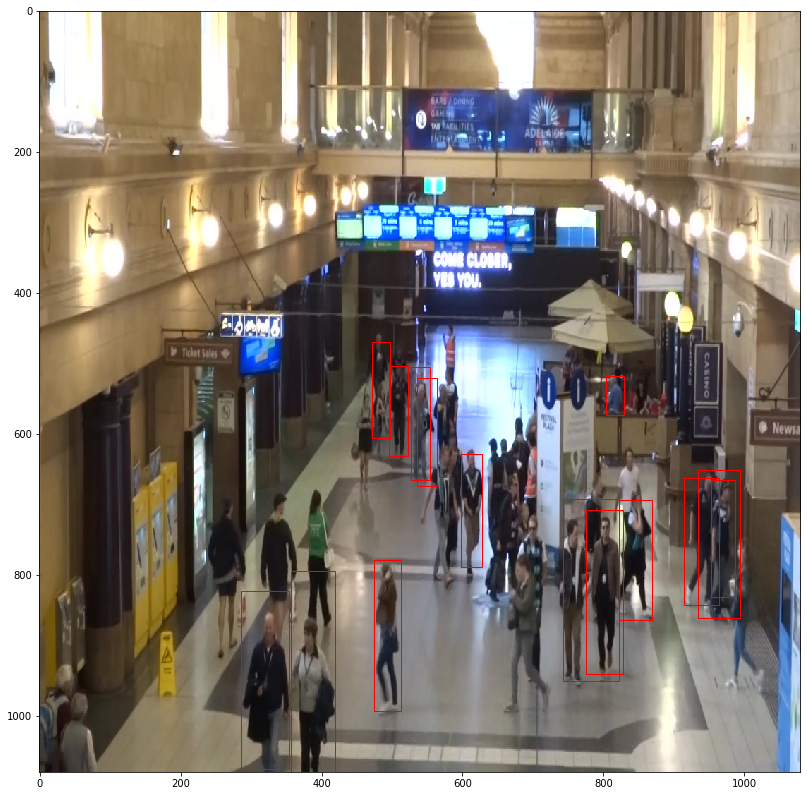

In [98]:
fig,ax = plt.subplots(1, figsize=(24,14))

# Display the image
ax.imshow(np.array(img_arr))

# Create a Rectangle patch
for i,labs in enumerate(response['pred_boxes']):
    if (response['pred_classes'][i]==0)&(response['scores'][i]>.2):
        rect = patches.Rectangle((labs[0], labs[1]),labs[2]-labs[0],labs[3]-labs[1] ,linewidth=1,edgecolor='r',facecolor='none') # 50,100),40,30
        ax.add_patch(rect)

plt.show()


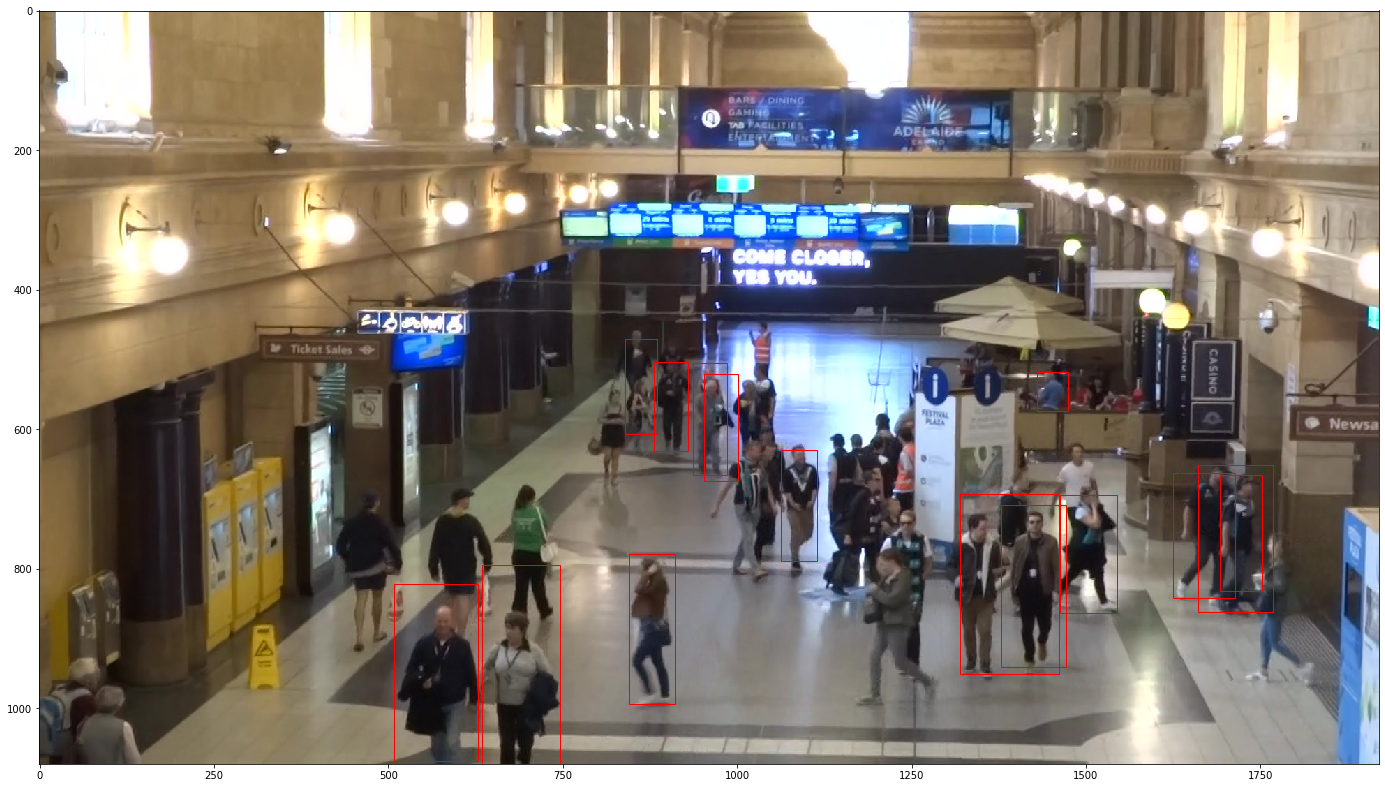

In [107]:
img = Image.open(img_paths[0])
img_arr = np.array(img)

fig,ax = plt.subplots(1, figsize=(24,14))

# Display the image
ax.imshow(np.array(img_arr))

# Create a Rectangle patch
for i,labs in enumerate(response['pred_boxes']):
    if (response['pred_classes'][i]==0)&(response['scores'][i]>.2):
        rect = patches.Rectangle((labs[0]*(1920/1080), labs[1]),(labs[2]-labs[0])*(1920/1080),labs[3]-labs[1] ,linewidth=1,edgecolor='r',facecolor='none') # 50,100),40,30
        ax.add_patch(rect)

plt.show()

In [102]:
labs[0]

949.03271484375

In [53]:

# serial_arr = npy_serializer(img_arr)
# nparr = np.frombuffer(serial_arr, np.uint8)
# img = cv2.imdecode(nparr, cv2.IMREAD_COLOR)
# input_object = np.asarray(img)
# input_object
# sys.getsizeof(init_response)

array(None, dtype=object)